# Painting GAN

## 개요

### 학습 목표

* 조건을 부여하여 생성 모델을 다루는 방법에 대해 이해합니다.
* cGAN 및 Pix2Pix의 구조와 학습 방법을 이해하고 잘 활용합니다.
* CNN 기반의 모델을 구현하는데 자신감을 갖습니다.

### 학습 전제

* Tensorflow의 Subclassing API로 레이어 및 모델을 구성하는 방법에 대해 대략적으로 알고 있어야 합니다.
* 신경망의 학습 방법에 대한 전반적인 절차를 알고 있어야 합니다.
* CNN, GAN에 대한 기본적인 개념을 알고 있어야 합니다.
* Tensorflow의 GradientTape API를 이용한 학습 코드를 보고 이해할 수 있어야 합니다.
* Tensorflow 내에서 잘 모르는 함수(또는 메서드)를 발견했을 때, 공식 문서에서 검색하고 이해해 보려는 의지가 필요합니다.

### 목차

* 조건 없는 생성 모델(Unconditional Generative Model), GAN
* 조건 있는 생성 모델(Conditional Generative Model), cGAN
* 내가 원하는 숫자 이미지 만들기 (1) Generator 구성하기
* 내가 원하는 숫자 이미지 만들기 (2) Discriminator 구성하기
* 내가 원하는 숫자 이미지 만들기 (3) 학습 및 테스트하기
* GAN의 입력에 이미지를 넣는다면? Pix2Pix
* 난 스케치를 할 테니 너는 채색을 하거라 (1) 데이터 준비하기
* 난 스케치를 할 테니 너는 채색을 하거라 (2) Generator 구성하기
* 난 스케치를 할 테니 너는 채색을 하거라 (3) Generator 재구성하기
* 난 스케치를 할 테니 너는 채색을 하거라 (4) Discriminator 구성하기
* 난 스케치를 할 테니 너는 채색을 하거라 (5) 학습 및 테스트하기
* 프로젝트 : Segmentation map으로 도로 이미지 만들기

## 조건 없는 생성모델

* Unconditional Generative Model), GAN
* 내가 원하는 종류의 이미지를 바로 생성하지 못함
* 내가 생성하고자하는 데이터에 대해 제어하기 힘듬

## 조건 있는 생성모델

* cGAN(Conditional Generative Model)
* 내가 원하는 종류의 이미지를 생성하고자 할 때 GAN이 가진 생성 과정의 불편함을 해소
* 내가 원하는 종류의 이미지를 생성

### GAN 목적 함수

* Generator, Discriminator 의 minmax game을 통한 경쟁으로 발전.
* Generator를 밑의 식을 최소화, Discriminator는 이 식을 최대화

$$ min_{G}max_{D}V (D,G) = $$
$$\mathbb{E}_{x \sim p_{data}(x)}[logD(x)] + \mathbb{E}_{z \sim p_{x}(z)}[log(1-D(G(z)))]$$

* z : 임의의 Noise
* D : Discriminator
* G : Generator
* 실제 이미지 1, 가짜 이미지 0

Discriminator
* $logD(x), log(1-D(G(z)))$ 모두 최대가 되어야함.
* 두 값이 모두 log 1이 되도록
* D(x) -> 1, D(G(z)) -> 0
* 진짜 데이터 x를 진짜로 가짜 데이터 G(z)를 가짜로 정확히 예측하도록 학습

Generator
* 첫번째 항은 상관없고 2번째 항인 $log(1-D(G(z)))$만 최소화
* 1-D(G(z))가 0이 되도록 = D(G(z))가 1이 되도록
* G는 z를 입력받아 생성한 데이터 G(z)를 D가 진짜라고 예측할 만큼 진짜 같은 가짜 데이터를 만들도록 학습

### cGAN의 목적 함수

$$ min_{G}max_{D}V (D,G) = $$
$$\mathbb{E}_{x \sim p_{data}(x)}[logD(x|y)] + \mathbb{E}_{z \sim p_{x}(z)}[log(1-D(G(z|y)))]$$

* GAN과 비교해서 D(x) -> D(x|y), D(G(z)) -> D(G(z|y))
* G, D의 입력에 특정 조건을 나타내는 정보 y를 같이 입력.
* y는 어떤 정보도 상관없으며, MNIST 경우 0~9의 label 정보
* Generator의 생성을 제어할 수 있음
* y : 임의 노이즈 입력 z의 가이드

## 내가 원하는 숫자 이미지 만들기

### Generator 구성하기

#### 데이터 준비하기

* tensorflow-datasets 에서 MNIST 데이터셋을 불러와봅시다.

2022-09-15 12:30:07.924308: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 12:30:08.355717: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6668 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5
2022-09-15 12:30:08.910324: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k)

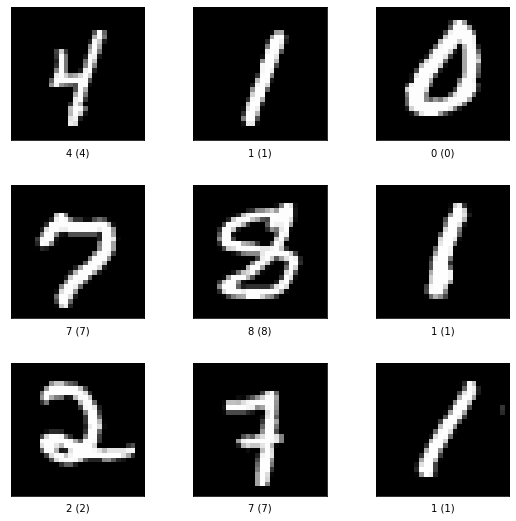

In [1]:
import tensorflow_datasets as tfds

mnist, info =  tfds.load(
    "mnist", split="train", with_info=True
)

fig = tfds.show_examples(mnist, info)

* 이미지 픽셀 값을 -1 ~ 1 사이의 범위
* 레이블 정보를 원-핫 인코딩(one-hot encoding)
* label 정보 사용 유무에 따라 gan_preprocessing, cgan_preprocessing 으로 나눔

In [2]:
import tensorflow as tf

BATCH_SIZE = 128

def gan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def cgan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    
    label = tf.one_hot(data["label"], 10)
    return image, label

gan_datasets = mnist.map(gan_preprocessing).shuffle(1000).batch(BATCH_SIZE)
cgan_datasets = mnist.map(cgan_preprocessing).shuffle(100).batch(BATCH_SIZE)

* 한 개만 확인
* 이미지와 라벨이 같아야함
* 이미지의 범위가 -1 ~ 1

Label : tf.Tensor([0. 0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
Image Min/Max : -1.0 1.0


2022-09-15 12:30:09.393343: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


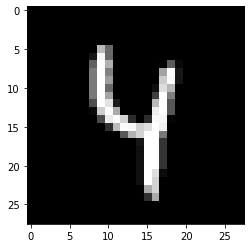

In [3]:
import matplotlib.pyplot as plt

for i,j in cgan_datasets : break

# 이미지 i와 라벨 j가 일치하는지 확인해 봅니다.     
print("Label :", j[0])
print("Image Min/Max :", i.numpy().min(), i.numpy().max())
plt.imshow(i.numpy()[0,...,0], plt.cm.gray)

#### GAN Generator 구성

* Tensorflow2의 Subclassing 이용
* Subclassing : tensorflow.keras.model 상속받아 클래스를 만들기.
* __init__() method 안에 레이어 구성을 정의, 구성된 레이어를 call() method에 사용해 forward propagation을 진행.

In [4]:
from tensorflow.keras import layers, Input, Model

class GeneratorGAN(Model):
    def __init__(self):
        super(GeneratorGAN, self).__init__()
        
        self.dense_1 = layers.Dense(128, activation='relu')
        self.dense_2 = layers.Dense(256, activation='relu')
        self.dense_3 = layers.Dense(512, activation='relu')
        self.dense_4 = layers.Dense(28*28*1, activation='tanh')
        
        self.reshape = layers.Reshape((28, 28, 1))
        
    def call(self, noise):
        out = self.dense_1(noise)
        out = self.dense_2(out)
        out = self.dense_3(out)
        out = self.dense_4(out)
        return self.reshape(out)

* init 안에 layer들을 정의했습니다.
* 4개의 FCN(Dense) 중 마지막을 제외하고는 모두 ReLU를 사용합니다.
* 결국 숫자 이미지를 출력해야하므로 출력 크기는 (28,28,1) 크기로 변환됩니다.

#### cGAN Generator 구성

In [5]:
class GeneratorCGAN(Model):
    def __init__(self):
        super(GeneratorCGAN, self).__init__()
        
        self.dense_z = layers.Dense(256, activation='relu')
        self.dense_y = layers.Dense(256, activation='relu')
        self.combined_dense = layers.Dense(512, activation='relu')
        self.final_dense = layers.Dense(28 * 28 * 1, activation='tanh')
        self.reshape = layers.Reshape((28, 28, 1))
        
    def call(self, noise, label):
        noise = self.dense_z(noise)
        label = self.dense_y(label)
        out = self.combined_dense(tf.concat([noise, label], axis=-1))
        out = self.final_dense(out)
        return self.reshape(out)

* cGAN은 GAN과 다르게 self,noise 에서 label 또한 입력받아서
* dense에 넣고 2개의 값을 연결하여 다시 layer에 넣습니다.

### Discriminator 구성

#### GAN Discriminator

In [6]:
class DiscriminatorGAN(Model):
    def __init__(self):
        super(DiscriminatorGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.blocks = []
        for f in [512, 256, 128, 1]:
            self.blocks.append(
                layers.Dense(f, activation=None if f==1 else "relu")
            )
        
    def call(self, x):
        x = self.flatten(x)
        for block in self.blocks:
            x = block(x)
        return x

* blocks를 통해 필요 레이어들을 차곡차곡 쌓아놓음 - FCN 매번 정의할 필요없음
* 입력 : Generator가 생성한 (28,28,1) 이미지
* 이를 fully connected로 학습하기 위해 flatten() 적용
* blocks와 for 문으로 하나씩 레이어를 꺼내 입력 데이터를 통과
* 마지막은 이미지를 나타내는 값 = 1개의 값이 나옴

#### cGAN Discriminator

* Maxout : 두 레이어를 연결할 때, 여러 개의 FCN layer를 통과시켜 그중 가장 큰 값을 가져오게 함.
* 2개의 FCN 사용할 때 Maxout 식

$$max(w_{1}^{T}x + b_{1}, w_{2}^{T}x + b_{2})$$

* 2개의 면이 교차된 모양의 activation function
* 1차원 FCN, 2개의 직선으로 이루어진 activation function으로 나타낼 수 있습니다.
* FCN 레이어 개수가 늘어나면 곡선 형태의 activation function이 될 수 있습니다.

In [7]:
class Maxout(layers.Layer):
    def __init__(self, units, pieces):
        super(Maxout, self).__init__()
        self.dense = layers.Dense(units*pieces, activation="relu")
        self.dropout = layers.Dropout(.5)    
        self.reshape = layers.Reshape((-1, pieces, units))
    
    def call(self, x):
        x = self.dense(x)
        x = self.dropout(x)
        x = self.reshape(x)
        return tf.math.reduce_max(x, axis=2)

* units, pieces 설정이 필요함.
* units 차원 수를 가지는 FCN layer를 pieces 개 만큼 만들고 그중 최댓값 출력
* 이 Maxout layer를 3번 사용하여 cGAN의 Discriminator를 구성할 수 있습니다.

In [8]:
class DiscriminatorCGAN(Model):
    def __init__(self):
        super(DiscriminatorCGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.image_block = Maxout(240, 5)
        self.label_block = Maxout(50, 5)
        self.combine_block = Maxout(240, 4)
        
        self.dense = layers.Dense(1, activation=None)
    
    def call(self, image, label):
        image = self.flatten(image)
        image = self.image_block(image)
        label = self.label_block(label)
        x = layers.Concatenate()([image, label])
        x = self.combine_block(x)
        return self.dense(x)

### 학습 및 테스트하기

* GAN과 cGAN 각각 모델 학습에 공통적으로 필요한 loss function과 optimizer를 정의
* 진짜 가짜 구별을 위한 Binary Cross Entropy를 사용, Adam optimizer를 이용해 학습.

### Binary Cross Entropy

In [9]:
from tensorflow.keras import optimizers, losses

bce = losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return bce(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    return bce(tf.ones_like(real_output), real_output) + bce(tf.zeros_like(fake_output), fake_output)

gene_opt = optimizers.Adam(1e-4)
disc_opt = optimizers.Adam(1e-4)

### GAN으로 MNIST 학습하기

* 입력 노이즈의 차원은 100, 하나의 배치 크기로 모델을 업데이트 하는 함수 설정

In [10]:
gan_generator = GeneratorGAN()
gan_discriminator = DiscriminatorGAN()

@tf.function()
def gan_step(real_images):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        # Generator를 이용해 가짜 이미지 생성
        fake_images = gan_generator(noise)
        # Discriminator를 이용해 진짜 및 가짜이미지를 각각 판별
        real_out = gan_discriminator(real_images)
        fake_out = gan_discriminator(fake_images)
        # 각 손실(loss)을 계산
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    # gradient 계산
    gene_grad = tape.gradient(gene_loss, gan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, gan_discriminator.trainable_variables)
    # 모델 학습
    gene_opt.apply_gradients(zip(gene_grad, gan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, gan_discriminator.trainable_variables))
    return gene_loss, disc_loss

* 어차피 낮은 epochs로는 좋은 결과를 구할 수 없으니 epoch를 1로 잡아봅시다.

In [11]:
EPOCHS = 1
for epoch in range(1, EPOCHS+1):
    for i, images in enumerate(gan_datasets):
        gene_loss, disc_loss = gan_step(images)

        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i+1} ITER] G:{gene_loss}, D:{disc_loss}")

[1/1 EPOCHS, 100 ITER] G:2.361910581588745, D:0.11856474727392197
[1/1 EPOCHS, 200 ITER] G:3.023789405822754, D:0.06902874261140823
[1/1 EPOCHS, 300 ITER] G:2.3702988624572754, D:0.1334068775177002
[1/1 EPOCHS, 400 ITER] G:3.3293590545654297, D:0.08570829033851624


* 100차원 노이즈 10개를 생성하여 10개의 숫자 손글씨 데이터를 생성해 시각화

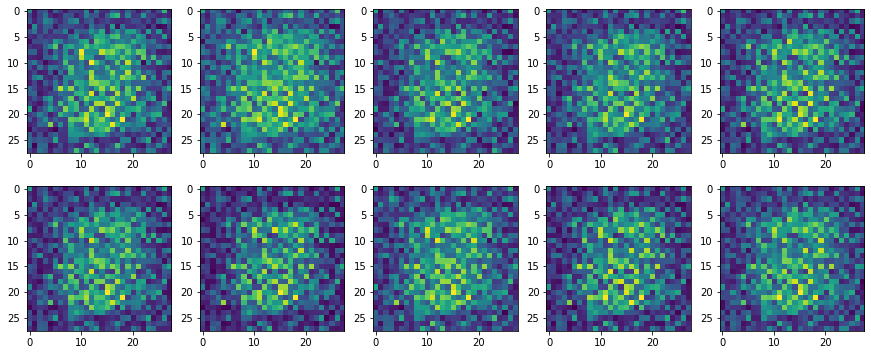

In [12]:
import numpy as np

noise = tf.random.normal([10, 100])

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

* 10 epochs로만은 좋은 데이터를 구할 수 없는 것 같습니다.
* 500 epoch로 학습한 가중치를 사용하겠습니다.

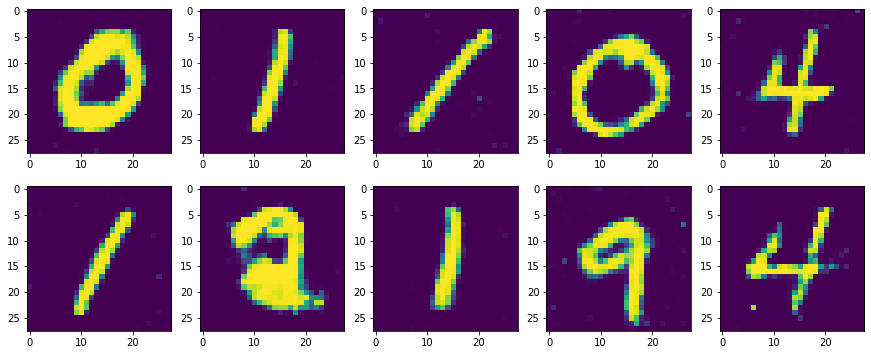

In [13]:
weight_path = 'data/GAN/GAN_500'

noise = tf.random.normal([10, 100]) 

gan_generator = GeneratorGAN()
gan_generator.load_weights(weight_path)

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

### cGAN으로 MNIST 학습하기

* cGAN도 어차피 낮은 epoch로는 좋은 결과를 얻을 수 없으니 epoch를 1로만 잡아봅시다.

In [14]:
cgan_generator = GeneratorCGAN()
cgan_discriminator = DiscriminatorCGAN()

@tf.function()
def cgan_step(real_images, labels):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        fake_images = cgan_generator(noise, labels)
        
        real_out = cgan_discriminator(real_images, labels)
        fake_out = cgan_discriminator(fake_images, labels)
        
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    
    gene_grad = tape.gradient(gene_loss, cgan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, cgan_discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_grad, cgan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, cgan_discriminator.trainable_variables))
    return gene_loss, disc_loss


EPOCHS = 1
for epoch in range(1, EPOCHS+1):
    
    for i, (images, labels) in enumerate(cgan_datasets):
        gene_loss, disc_loss = cgan_step(images, labels)
    
        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i} ITER] G:{gene_loss}, D:{disc_loss}")

[1/1 EPOCHS, 99 ITER] G:4.5752458572387695, D:0.017641259357333183
[1/1 EPOCHS, 199 ITER] G:4.051941394805908, D:0.023738857358694077
[1/1 EPOCHS, 299 ITER] G:4.795965671539307, D:0.015915215015411377
[1/1 EPOCHS, 399 ITER] G:5.637945175170898, D:0.008642411790788174


* 결국 학습 과정에서 Label 정보만 추가로 입력했다는 점을 제외하면 GAN과 큰 차이는 없습니다.
* cGAN 역시 500 epochs 한 가중치를 사용하겠습니다.

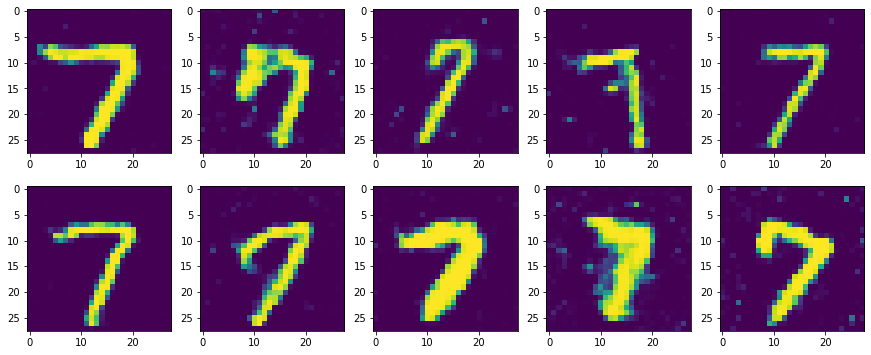

In [15]:
number = 7  # TODO : 생성할 숫자를 입력해 주세요!!

weight_path = 'data/CGAN/CGAN_500'

noise = tf.random.normal([10, 100])

label = tf.one_hot(number, 10)
label = tf.expand_dims(label, axis=0)
label = tf.repeat(label, 10, axis=0)

generator = GeneratorCGAN()
generator.load_weights(weight_path)

output = generator(noise, label)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

## Pix2Pix

### 설명

* 기존의 noise를 이미지로 변환하는 일반적인 GAN이 아님.
* 이미지를 입력으로하여 원하는 형태의 이미지로 변환 할 수 있는 GAN 모델.
* 이미지간 변환(Image-to-Image Translation)
* Pix2Pix : 한 이미지의 픽셀에서 다른 이미지의 픽셀로(pixel to pixel) 변환한다는 뜻
* cGAN은 FCN layer를 연속적으로 쌓아 만들었지만, 이미지 변환이 목적인 Pix2Pix은 이미지를 다루는데 효과적인 convolution layer를 사용합니다.
* 하지만 GAN 구조 기반이므로 Generator, Discriminator 2가지 구성 요소로 이루어집니다.

#### Generator

* Generator는 어떠한 이미지를 입력받아 변환된 이미지를 출력하기 위해 사용됩니다.
* 입력 이미지와 변환된 이미지의 크기는 동일
* Encoder-Decoder의 구조

<img src = 'image/U_NET.png' width = 50% height = 50% >

* Encoder와 Decoder가 연결되어 있다.(skip connection)
* Decoder가 더 잘 생성하도록 더 많은 추가 정보를 이용
* 이러한 U-NET 구조는 단순한 구조보다 비교적 선명한 결과를 얻어낼 수 있다.

#### Loss function

* 변환하고자 하는 이미지를 Encoder에 입력하여 Decoder의 출력으로 변환된 이미지를 얻을 수 있다.
* 이미지 차이를 L1(MAE), L2(MSE) 같은 손실로 계산한 후 이를 역전파하여 네트워크 학습.
* 변환된 이미지 품질이 문제 : L1, L2 손실로만 학습하는 경우 결과가 흐릿해지는 경향이 있음 - 단순히 이미지의 평균적인 손실만 줄이고자 파라미터를 학습
* L1 + GAN 손실을 사용하면 더욱더 좋은 결과를 얻을 수 있다고 합니다.

#### Discriminator

* DCGAN의 Discriminator 는 Convolution Layer를 이용해 점점 크기를 줄여나가면서, 최종적으로 하나의 이미지에 대한 하나의 확률 값을 출력.
* -> 하나의 전체 이미지에 대해 하나의 확률 값만을 도출하는 것이 진짜 혹은 가짜를 판별하는 데 좋은 것일까?
* 그리하여 조금 다른 Discriminator를 사용합니다.
* 이미지 출처 [출처 : https://arxiv.org/pdf/1803.07422.pdf]

<img src = 'image/Discriminator.png' height = 30% width = 30%>

* 파란 점선은 여러개의 출력 중 하나의 출력을 계산하기 위한 입력 이미지의 receptive field 영역.
* 전체 영역을 다 보는 것이 아닌 일부 영역에 대해서만 진짜/가짜를 판별하는 하나의 확률 값을 도출
* 해당 값들을 평균하여 최종 Discriminator의 출력을 생성
* 이를 이미지의 일부분(patch)를 이용한다하여 patchGAN이라 부름.
* 거리가 먼 두 픽셀은 서로 연관성이 거의 없기 때문에 특정 크기를 가진 일부 영역에서 세부적으로 진짜/가짜를 판별하는 것이 더 좋다

### 데이터 준비하기

* [Sketch2Pokemon](https://www.kaggle.com/datasets/norod78/sketch2pokemon)

In [16]:
import os

data_path = 'data/pokemon/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 830


* 임의로 6장 시각화

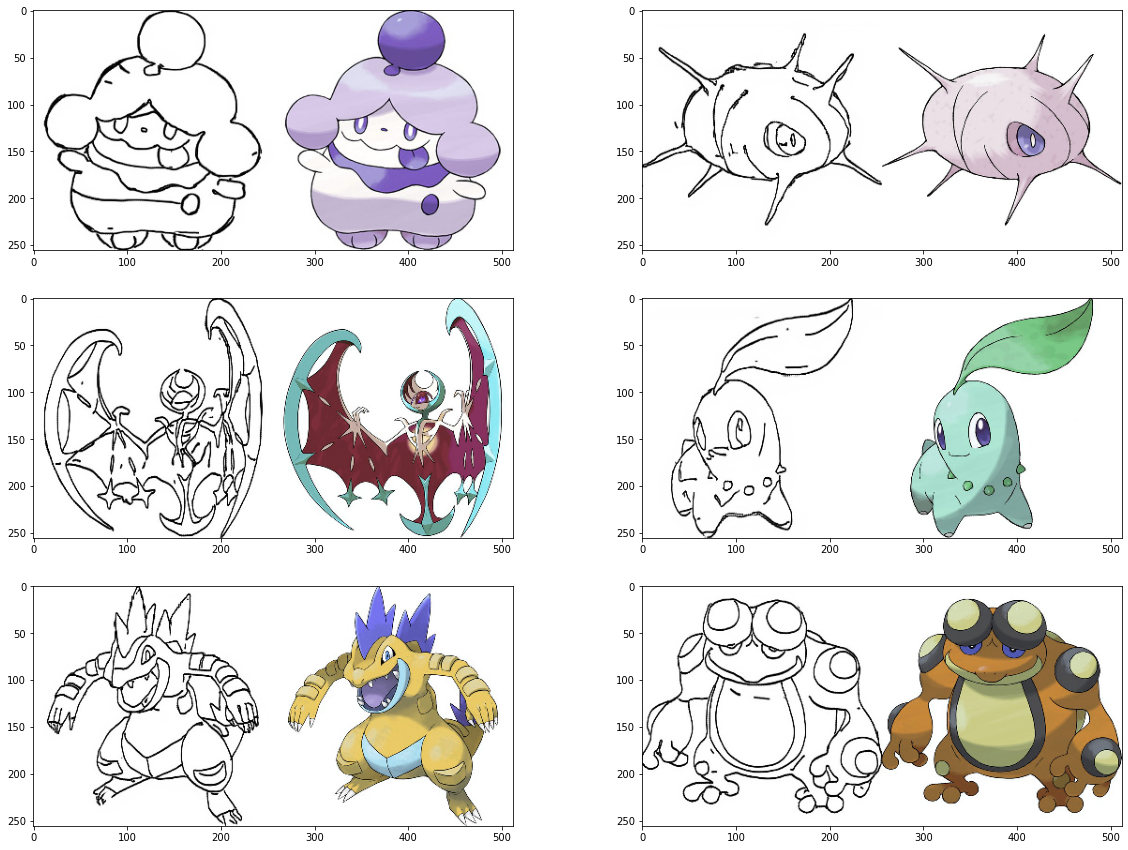

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

* 스케치와 실제 포켓몬 이미지가 함께 포함되어있음.
* 크기 확인

In [18]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


* (256, 512, 3) 입니다.
* (256, 256, 3) 크기의 2개의 이미지로 분할하여 사용

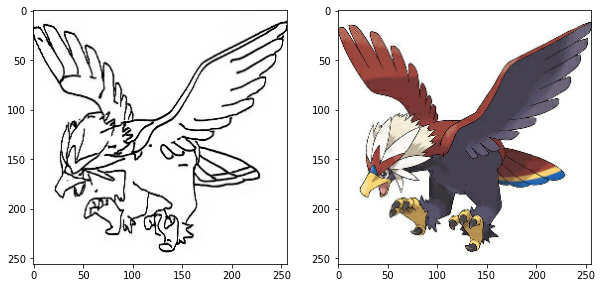

In [19]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

* 사용할 수 있는 데이터가 800개 뿐이다.
* 다양성을 높이기 위해 augmentation 방법을 적용

In [20]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

* apply_augmentation 함수는 스케치 및 채색된 2개 이미지를 입력으로 받아 여러 가지 연산을 두 이미지에 동일하게 적용
1. 두 이미지가 채널 축으로 연결됩니다. (tf.concat). 두 이미지가 각각 3채널인 경우 6채널이 됩니다.  
2. 1.의 결과에 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼적용됩니다. (tf.pad)
3. 2.의 결과에서 (256,256,6) 크기를 가진 이미지를 임의로 잘라냅니다. (tf.image.random_crop)
4. 3.의 결과를 50% 확률로 가로로 뒤집습니다. (tf.image.random_flip_left_right)
5. 4.의 결과를 50% 확률로 세로로 뒤집습니다. (tf.image.random_flip_up_down)
6. 5.의 결과를 50% 확률로 회전시킵니다. (tf.image.rot90)  
* 만들어진 애들을 출력해 봅시다.

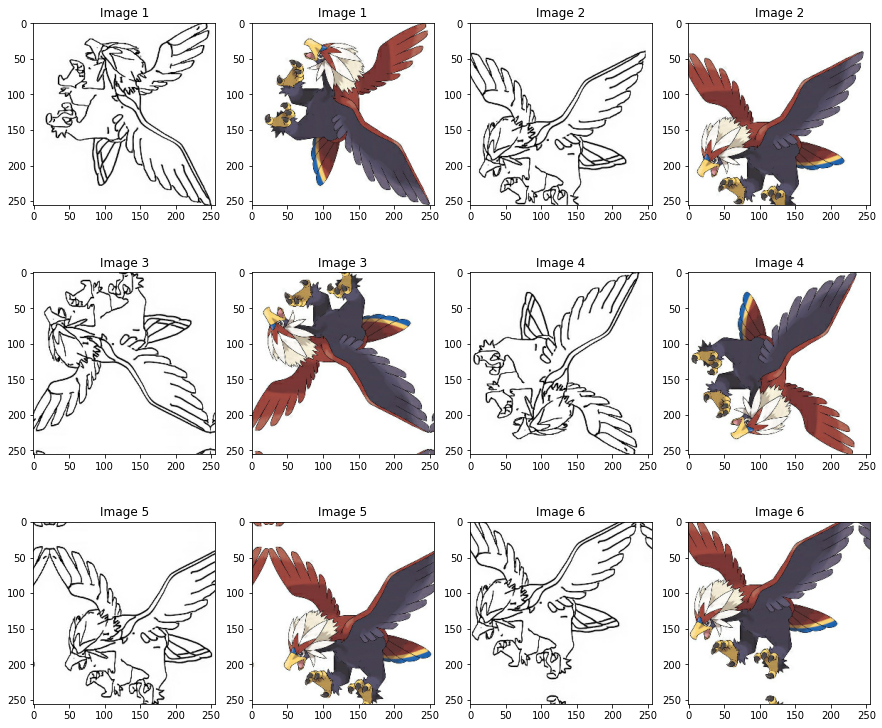

In [21]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

* 마지막으로 위 과정들을 학습 데이터에 적용하며, 잘 적용되었는지 하나의 이미지만 시각화하여 확인

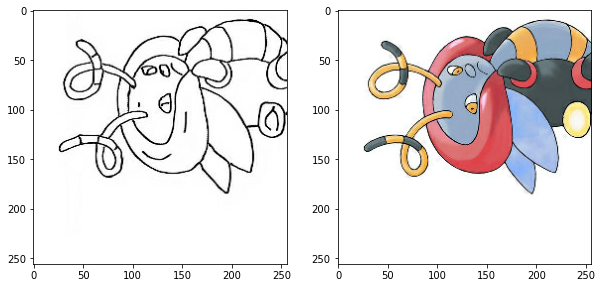

In [22]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

### Generator 구성하기

* Ck : Convolution-BatchNorm-ReLU layer with k filters
* CDk : Convolutoin-BatchNorm-Dropout-ReLU - Dropout rate 50%
* Convolution : 4X4 spatial filters, stride 2
* Encoder downsample by factor of 2, decoder upsample by factor of 2
* 0.2 slope leakly ReLU

* n_filters와 use_bn을 통해 필터의 개수와 BatchNorm 사용 여부를 결정
* Convolution의 filter size(4), stride(2), slope(0.2)는 고정이므로 따로 지정

### Encoder

In [23]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

* 여러개의 Encoder 블록을 사용하여 Encoder를 만듬

In [24]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

* (256,256,3)을 넣었을 때 나오는 형태를 요약

In [25]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 encode_block (EncodeBlock)  (None, 128, 128, 64)      3072      
                                                                 
 encode_block_1 (EncodeBlock  (None, 64, 64, 128)      131584    
 )                                                               
                                                                 
 encode_block_2 (EncodeBlock  (None, 32, 32, 256)      525312    
 )                                                               
                                                                 
 encode_block_3 (EncodeBlock  (None, 16, 16, 512)      2099200   
 )                                                               
                                                             

### Decoder

In [26]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,512)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [27]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 1, 512)]       0         
                                                                 
 decode_block (DecodeBlock)  (None, 2, 2, 512)         4196352   
                                                                 
 decode_block_1 (DecodeBlock  (None, 4, 4, 512)        4196352   
 )                                                               
                                                                 
 decode_block_2 (DecodeBlock  (None, 8, 8, 512)        4196352   
 )                                                               
                                                                 
 decode_block_3 (DecodeBlock  (None, 16, 16, 512)      4196352   
 )                                                               
                                                           

* 최종값이 (256,256,3)이 되었습니다.

### Generator 생성

* Encoder와 Decoder를 연결시켜서 Generator를 구성해보기

In [28]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 encoder_1 (Encoder)         (None, 1, 1, 512)         19544576  
                                                                 
 decoder_1 (Decoder)         (None, 256, 256, 3)       19542784  
                                                                 
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


## Generator 재구성하기

* 기존의 EncodeBlock, DecodeBlock

In [29]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

* U-Net Generator
* init에서 사용할 블록 모두 정의
* call에서 forward propagation
* skip-connection이 call() 내부에 어떻게 구현 되었는지 확인

In [30]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [31]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block_16 (EncodeBlock)  (None, 128, 128, 64  3072        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 encode_block_17 (EncodeBlock)  (None, 64, 64, 128)  131584      ['encode_block_16[0][0]']        
                                                                                            

## Discriminator

* 최종 출력 크기가 (30,30,1)이 되어야하는 이유는 앞서 Discrimintor에 대해 알아봤던 70x70 PatchGAN을 사용했기 때문
* 최종 (30,30) 출력에서 픽셀의 receptive field의 크기를 (70,70)으로 맞추기 위해 Discriminator 출력 크기를 (30,30) 크기로 강제로 맞춤

* init 에서 필요한 만큼 많은 설정을 가능하게 함
* 필터의 수(n_filters)
* 필터가 순회하는 간격(stride)
* 출력 feature map의 크기를 설정할 수 있는 패딩 설정(custom_pad), BatchNorm의 사용 여부(use_bn), 활성화 함수 사용 여부(act)가 설정 가능

In [32]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [33]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 32)]    0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 130, 130, 32)     0         
 2D)                                                             
                                                                 
 conv2d_24 (Conv2D)          (None, 127, 127, 64)      32768     
                                                                 
 batch_normalization_45 (Bat  (None, 127, 127, 64)     256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 127, 127, 64)      0         
                                                                 
Total params: 33,024
Trainable params: 32,896
Non-trainable

In [34]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [35]:
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 6)  0           ['input_6[0][0]',                
                                                                  'input_7[0][0]']          

* 두 개의 (256,256,3) 크기 입력으로 최종 (30,30,1) 출력을 만들었고, 아래의 Discriminator를 나타낸 그림과 각 출력 크기가 일치

2022-09-15 17:03:42.911877: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204


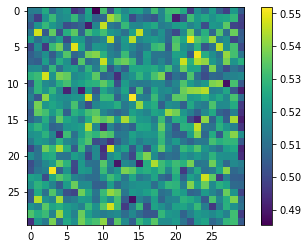

In [36]:
import tensorflow as tf
import matplotlib.pyplot as plt

x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

## 학습 및 테스트하기

* Generator의 손실 함수 (위 코드의 get_gene_loss)는 총 3개의 입력이 있습니다.
* 이 중 fake_disc는 Generator가 생성한 가짜 이미지를 Discriminator에 입력하여 얻어진 값이며, 실제 이미지를 뜻하는 "1"과 비교하기 위해 tf.ones_like()를 사용합니다.
* 또한 L1 손실을 계산하기 위해 생성한 가짜 이미지(fake_output)와 실제 이미지(real_output) 사이의 MAE(Mean Absolute Error)를 계산합니다.
* Discriminator의 손실 함수 (위 코드의 get_disc_loss)는 2개의 입력이 있으며, 이들은 가짜 및 진짜 이미지가 Discriminator에 각각 입력되어 얻어진 값입니다.
* Discriminator는 실제 이미지를 잘 구분해 내야 하므로 real_disc는 "1"로 채워진 벡터와 비교하고, fake_disc는 "0"으로 채워진 벡터와 비교합니다.

In [37]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [38]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

* 하나의 배치 크기만큼 데이터를 입력했을 때 가중치를 1회 업데이트하는 과정은 아래와 같이 구현했습니다.
* L1 loss와 GAN loss를 더하는데 L1 손실에 100을 곱하였습니다.

In [39]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

* 10 epochs로 학습

In [40]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:1.0354                     
L1_loss:0.4801                     
Discriminator_loss:1.2082

EPOCH[1] - STEP[20]                     
Generator_loss:0.8724                     
L1_loss:0.3099                     
Discriminator_loss:1.5402

EPOCH[1] - STEP[30]                     
Generator_loss:1.2394                     
L1_loss:0.2848                     
Discriminator_loss:1.4261

EPOCH[1] - STEP[40]                     
Generator_loss:1.1060                     
L1_loss:0.2934                     
Discriminator_loss:1.0017

EPOCH[1] - STEP[50]                     
Generator_loss:1.3628                     
L1_loss:0.2013                     
Discriminator_loss:1.3587

EPOCH[1] - STEP[60]                     
Generator_loss:1.1818                     
L1_loss:0.3377                     
Discriminator_loss:1.0482

EPOCH[1] - STEP[70]                     
Generator_loss:1.2364                     
L1_loss:0.2640                    

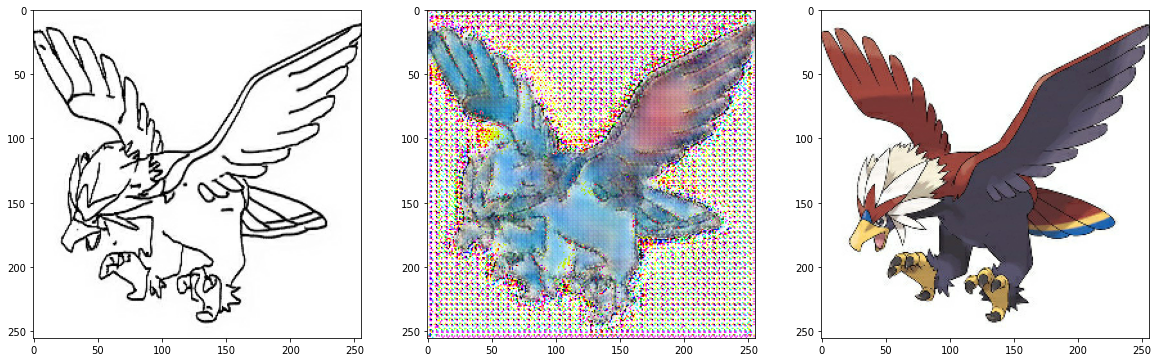

In [41]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))